# Metal Defect Classifier
- This application of detecting defect on metal surface is an example of how deep learning can be implemented to Industrial Processes. 
- It will reduce the inprocess error and add a middle layer to quality inspection.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras as ks
import os
import cv2

In [16]:
train_dir = "../input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/"
test_dir = "../input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/test/"

In [27]:
def get_image(path):
    img = cv2.imread(path,0)
    print(img.shape)
    plt.imshow(img,cmap="gray")

In [28]:
image = "../input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/def_front/cast_def_0_0.jpeg"

(300, 300)


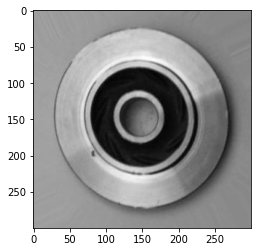

In [30]:
get_image(image)

## Create Image Data Generator

In [101]:
def datapreprocessing(main_dir,bsize):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
    train_gen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   #fill_mode='nearest'
                                  )

    train_generator = train_gen.flow_from_directory(
        directory=main_dir,
        target_size=(64,64),
        batch_size=bsize,
        color_mode="grayscale",
        shuffle=True,
        subset="training",
        class_mode='binary')
    
    return train_generator

In [102]:
traingen = datapreprocessing(train_dir,20)
validgen = datapreprocessing(test_dir,20)

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [103]:
labelnames = traingen.class_indices
labelnames

{'def_front': 0, 'ok_front': 1}

In [104]:
#Function that can build a dataframe on passing folderpath.
def getdata(folder_path):
    sig = pd.DataFrame(columns=['image_abs_path','image_labels'])
    for key,value in labelnames.items():
        #print("processing for label: {}".format(label))
        label_i = folder_path+"/"+str(key)
        #read directory
        dirs_label_i =  os.listdir(label_i)
        idx = 0
        for image in dirs_label_i:
            #create a absolute image path
            sig_i = os.path.join(label_i,image)
            #print('Absolute path for image no. {} and label {}: {}'\
                  #.format(idx,label,flower_i))

            #fill the dataframe with path and label
            sig = sig.append({'image_abs_path':sig_i,
                            'image_labels':key},
                           ignore_index=True)
            idx += 1
    return sig

In [105]:
#Create Train Dataframe as repository of paths and labels.
valid = getdata(test_dir)

In [106]:
valid

,image_abs_path,image_labels
0,../input/real-life-industrial-dataset-of-casti...,def_front
1,../input/real-life-industrial-dataset-of-casti...,def_front
2,../input/real-life-industrial-dataset-of-casti...,def_front
3,../input/real-life-industrial-dataset-of-casti...,def_front
4,../input/real-life-industrial-dataset-of-casti...,def_front
...,...,...
710,../input/real-life-industrial-dataset-of-casti...,ok_front
711,../input/real-life-industrial-dataset-of-casti...,ok_front
712,../input/real-life-industrial-dataset-of-casti...,ok_front
713,../input/real-life-industrial-dataset-of-casti...,ok_front


In [107]:
# Fetch n number of images from train data frame
def get_n_images(n,df,label):
    import warnings
    warnings.filterwarnings('ignore')
    train = df[df["image_labels"]==label]
    print(len(train))
    i = 0
    m = n/2
    plt.figure(figsize=(12, 6))
    for path in train['image_abs_path'][0:n]:
        plt.subplot(2,m,i+1)
        get_image(path)
        #plt.title(train['image_labels'][i])
        i += 1
    plt.tight_layout()
    plt.show()

In [110]:
def visualize_gen(train_generator):   
    #Visualising Images Processed
    plt.figure(figsize=(6, 3))
    for i in range(0, 10):
        plt.subplot(2, 5, i+1)
        for X_batch, Y_batch in train_generator:
            image = X_batch[0]        
            plt.axis("off")
            plt.imshow((image*255).astype(np.uint8),cmap='gray')
            break
    plt.tight_layout()
    plt.show()

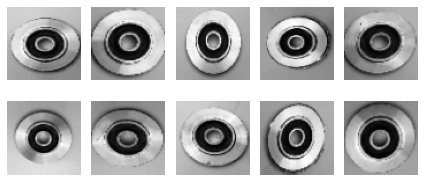

In [111]:
visualize_gen(traingen)

In [112]:
input_shape = traingen.image_shape
input_shape

(64, 64, 1)

## Build Model's Architecture

In [113]:
def imageclf2(input_shape):
    from tensorflow import keras as ks
    #from tensorflow.keras import regularizers
    model = ks.models.Sequential()
    #building architecture
    #Adding layers
    model.add(ks.layers.Conv2D(8,(3,3),
                               strides=1,
                               activation="relu",
                               padding='same',
                               name="layer1",
                               input_shape=input_shape))
    model.add(ks.layers.MaxPooling2D(pool_size=2,strides=2))
    #model.add(ks.layers.Dropout(0.5))
    model.add(ks.layers.Conv2D(8,(3,3),strides=1,padding="same",activation="relu",name="layer2"))
    model.add(ks.layers.MaxPooling2D(pool_size=2,strides=2))
#     model.add(ks.layers.Dropout(0.5))
#     model.add(ks.layers.Conv2D(64,(3,3),strides=1,padding="same",activation="relu",name="layer3"))
#     model.add(ks.layers.MaxPooling2D(pool_size=2,strides=2))
#     model.add(ks.layers.Dropout(0.5))
#     model.add(ks.layers.Conv2D(64,(3,3),strides=1,padding="same",activation="relu",name="layer4"))
#     model.add(ks.layers.MaxPooling2D(pool_size=2,strides=2))
#     model.add(ks.layers.Dropout(0.5))
    
    
    model.add(ks.layers.Flatten())
    model.add(ks.layers.Dense(128,activation="relu",
                              name="layer5"))
    model.add(ks.layers.Dense(128,activation="relu",
                              name="layer6"))
    #model.add(ks.layers.Dropout(0.5))
    
    model.add(ks.layers.Dense(1,activation="sigmoid",
                              name="output"))
    model.summary()
    
    return model


## Build the Compiler

In [114]:
def compiler2(model,train_generator,valid_generator,epchs,bsize=32,lr=0.0001):

    from tensorflow import keras as ks
    callbck = ks.callbacks.EarlyStopping(monitor='val_loss',patience=10,
                                         verbose=2,
                                         restore_best_weights=True,) 
    
    opt = ks.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss="binary_crossentropy",
                      optimizer=opt,
                      metrics=["accuracy"])
    history = model.fit(train_generator,
                        epochs=epchs,
                        callbacks=[callbck],
                        validation_data=valid_generator,
                        verbose = 1,
                        #steps_per_epoch = train_generator.n // bsize
                       )
    #Visualise curves
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='valid_acc')

    plt.title('lrate='+str(lr), pad=-50)
    plt.legend()
    plt.grid(True)
    return model,history

### Fit Model and Evaluate

In [115]:
model01 = imageclf2(input_shape)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Conv2D)              (None, 64, 64, 8)         80        
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
layer2 (Conv2D)              (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
layer5 (Dense)               (None, 128)               262272    
_________________________________________________________________
layer6 (Dense)               (None, 128)              

Epoch 1/10
332/332 [==============================] - 26s 78ms/step - loss: 0.6748 - accuracy: 0.5795 - val_loss: 0.6179 - val_accuracy: 0.6573
Epoch 2/10
332/332 [==============================] - 26s 78ms/step - loss: 0.5817 - accuracy: 0.7040 - val_loss: 0.5290 - val_accuracy: 0.7343
Epoch 3/10
332/332 [==============================] - 26s 78ms/step - loss: 0.5206 - accuracy: 0.7509 - val_loss: 0.4673 - val_accuracy: 0.7650
Epoch 4/10
332/332 [==============================] - 26s 77ms/step - loss: 0.4528 - accuracy: 0.7911 - val_loss: 0.4089 - val_accuracy: 0.7972
Epoch 5/10
332/332 [==============================] - 26s 78ms/step - loss: 0.4008 - accuracy: 0.8207 - val_loss: 0.3680 - val_accuracy: 0.8392
Epoch 6/10
332/332 [==============================] - 26s 77ms/step - loss: 0.3571 - accuracy: 0.8445 - val_loss: 0.4174 - val_accuracy: 0.8280
Epoch 7/10
332/332 [==============================] - 26s 78ms/step - loss: 0.3335 - accuracy: 0.8607 - val_loss: 0.3023 - val_accuracy:

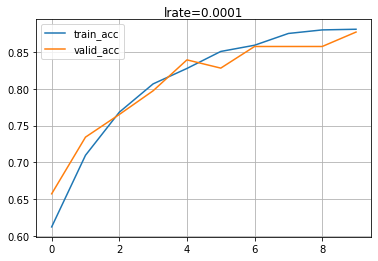

In [116]:
model_com01 = compiler2(model01,traingen,validgen,10)

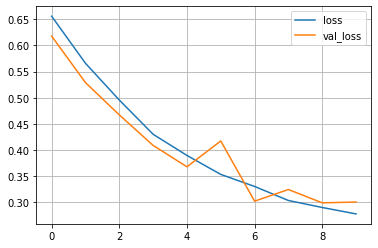

In [117]:
#Visualise loss curves
history = model_com01[1]
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

### Get Prediction and visualise the output.

In [118]:
def get_predictions(n):
    import keras as ks
    image1= validgen[0][0][n]
    #print(image1.shape)
    plt.imshow(image1)
    input_arr = ks.preprocessing.image.img_to_array(validgen[0][0][n])
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    predictions = model_com01[0].predict_classes(input_arr)
    #our dictionary starts from 1 whereas model has classes from 0.
    return predictions

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0]], dtype=int32)

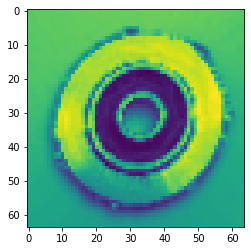

In [119]:
get_predictions(10)